
# 🌳 Détection de déforestation — Pipeline ResNet50 (TensorFlow/Keras)

**Objectif :** pipeline complet, robuste et reproductible pour classer des patches *déforestation* vs *no\_deforestation* à partir d'images dans le dossier `archive/`.

**Points clés :**
- Chargement **stratifié** avec `image_dataset_from_directory`
- **Augmentation** "on-the-fly" (pas sur disque)
- **Prétraitement** `preprocess_input` compatible ResNet
- Gestion du **déséquilibre** (`class_weight`)
- **Callbacks** (EarlyStopping, ReduceLROnPlateau, Checkpoint)
- **Fine-tuning** léger (queue de ResNet)
- Évaluation avec **seuil optimal** (F1) + matrice de confusion
- **TTA** 

> Arborescence attendue :  
> `archive/` contient **deux sous-dossiers** : `no_deforestation/` et `deforestation/`.


In [1]:

# =========================
# 0) Préambule & versions
# =========================
import os, random, numpy as np, tensorflow as tf
from pathlib import Path

SEED = 1337
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print("TensorFlow:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Répertoire projet (ce notebook doit être lancé depuis la racine du projet)
BASE_DIR = Path.cwd()
DATA_DIR = (BASE_DIR / "archive").as_posix()  # archive/no_deforestation, archive/deforestation
IMG_SIZE = (224, 224)
BATCH    = 32


TensorFlow: 2.15.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:

# ======================================
# 1) Chargement images & split intégrés
# ======================================
from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",     # 0/1
    class_names=["no_deforestation", "deforestation"],  # ordre fixé
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
)

val_ds = image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    class_names=["no_deforestation", "deforestation"],
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH,
)

num_train = train_ds.cardinality().numpy() * BATCH
num_val   = val_ds.cardinality().numpy() * BATCH
print("Batches train:", train_ds.cardinality().numpy(), "  (≈", num_train, "images)")
print("Batches val  :", val_ds.cardinality().numpy(), "  (≈", num_val,   "images)")


Found 4122 files belonging to 2 classes.
Using 3298 files for training.
Found 4122 files belonging to 2 classes.
Using 824 files for validation.


2025-10-10 13:47:44.596383: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-10-10 13:47:44.596423: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-10-10 13:47:44.596432: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-10-10 13:47:44.596676: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-10 13:47:44.597117: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Batches train: 104   (≈ 3328 images)
Batches val  : 26   (≈ 832 images)


In [3]:

# ============================================
# 2) Augmentation "on-the-fly" + preprocess
# ============================================
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet import preprocess_input

augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(1.0),
    layers.RandomZoom(0.10),
    layers.RandomTranslation(0.05, 0.05),
])

def add_preproc(ds, training=True):
    ds = ds.map(lambda x,y: (tf.cast(x, tf.float32), y))
    if training:
        ds = ds.map(lambda x,y: (augment(x), y))
    ds = ds.map(lambda x,y: (preprocess_input(x), y))
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds_pp = add_preproc(train_ds, training=True)
val_ds_pp   = add_preproc(val_ds,   training=False)


In [4]:

# ==================================
# 3) Gestion du déséquilibre (poids)
# ==================================
# On parcourt le train_ds (sans préproc nécessaire) pour collecter les labels
ys_list = []
for xb, yb in train_ds:
    ys_list.append(yb.numpy())
ys = np.concatenate(ys_list, axis=0)

classes, counts = np.unique(ys, return_counts=True)
class_weight = {int(c): float(sum(counts)/(len(classes)*cnt)) for c, cnt in zip(classes, counts)}
print("Répartition train:", dict(zip(classes, counts)))
print("class_weight     :", class_weight)


Répartition train: {0: 1622, 1: 1676}
class_weight     : {0: 1.0166461159062885, 1: 0.983890214797136}


In [5]:

# ============================================
# 4) Modèle = ResNet50 gelé + tête légère
# ============================================
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import models, optimizers

base = ResNet50(weights="imagenet", include_top=False, input_shape=IMG_SIZE+(3,))
base.trainable = False  # phase 1: on gèle le backbone

inputs = layers.Input(IMG_SIZE+(3,))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(2, activation="softmax")(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________

In [6]:

# =======================
# 5) Callbacks pratiques
# =======================
cbs = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, monitor="val_loss"),
    tf.keras.callbacks.ModelCheckpoint("best_resnet_model.keras", save_best_only=True, monitor="val_loss"),
]


In [7]:

# ==============================
# 6) Entraînement (phase 1 gelée)
# ==============================
history = model.fit(
    train_ds_pp,
    validation_data=val_ds_pp,
    epochs=10,
    class_weight=class_weight,
    callbacks=cbs,
    verbose=1
)


2025-10-10 13:47:47.820432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2025-10-10 13:47:48.865371: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


104/104 [==============================] - 42s 388ms/step - loss: 0.3382 - accuracy: 0.8511 - val_loss: 0.2799 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 2/10
104/104 [==============================] - 39s 377ms/step - loss: 0.2320 - accuracy: 0.9027 - val_loss: 0.2812 - val_accuracy: 0.8835 - lr: 0.0010
Epoch 3/10
104/104 [==============================] - 43s 411ms/step - loss: 0.2174 - accuracy: 0.9081 - val_loss: 0.2482 - val_accuracy: 0.9029 - lr: 0.0010
Epoch 4/10
104/104 [==============================] - 43s 412ms/step - loss: 0.2095 - accuracy: 0.9136 - val_loss: 0.2781 - val_accuracy: 0.8811 - lr: 0.0010
Epoch 5/10
104/104 [==============================] - 58s 559ms/step - loss: 0.2034 - accuracy: 0.9178 - val_loss: 0.2192 - val_accuracy: 0.9163 - lr: 0.0010
Epoch 6/10
104/104 [==============================] - 55s 529ms/step - loss: 0.1887 - accuracy: 0.9230 - val_loss: 0.2286 - val_accuracy: 0.9126 - lr: 0.0010
Epoch 7/10
104/104 [==============================] - 65s 624ms

In [8]:

# ====================================
# 7) Fine-tuning léger (fin de conv5)
# ====================================
# Dégèle un petit paquet de couches terminales
for l in base.layers[-30:]:
    l.trainable = True

model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds_pp,
    validation_data=val_ds_pp,
    epochs=10,
    class_weight=class_weight,
    callbacks=cbs,
    verbose=1
)


Epoch 1/10


2025-10-10 13:56:47.346733: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


104/104 [==============================] - 53s 475ms/step - loss: 0.1601 - accuracy: 0.9360 - val_loss: 0.1955 - val_accuracy: 0.9345 - lr: 1.0000e-05
Epoch 2/10
104/104 [==============================] - 49s 473ms/step - loss: 0.1691 - accuracy: 0.9357 - val_loss: 0.1956 - val_accuracy: 0.9345 - lr: 1.0000e-05
Epoch 3/10
104/104 [==============================] - 48s 463ms/step - loss: 0.1655 - accuracy: 0.9348 - val_loss: 0.1956 - val_accuracy: 0.9333 - lr: 1.0000e-05
Epoch 4/10
104/104 [==============================] - 48s 456ms/step - loss: 0.1615 - accuracy: 0.9366 - val_loss: 0.1955 - val_accuracy: 0.9345 - lr: 1.0000e-05


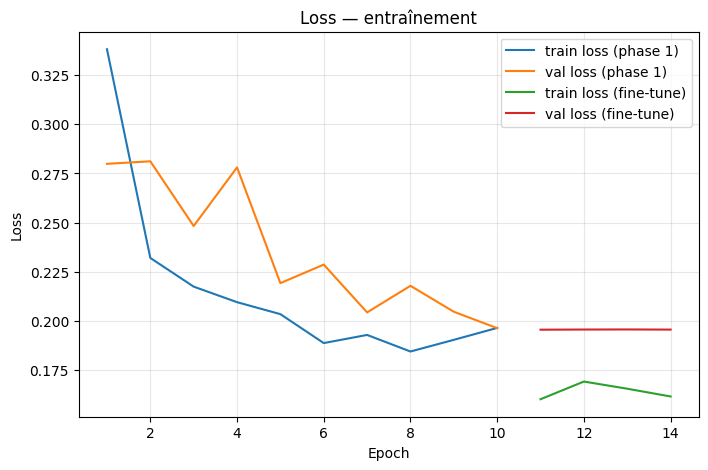

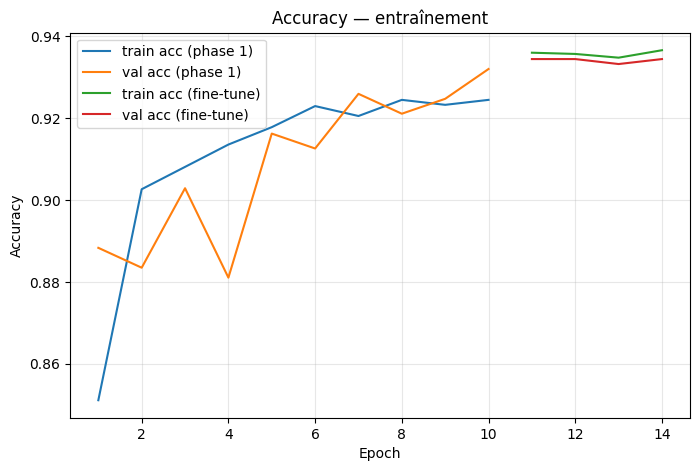

In [9]:
import matplotlib.pyplot as plt

def plot_training_curves(history, history_ft=None, savepath=None):
    """
    Affiche loss et accuracy (train/val) pour l'entraînement (history)
    et, si fourni, la phase de fine-tuning (history_ft).
    """
    # Récupère les métriques
    def extract(h):
        return {
            "loss": h.history.get("loss", []),
            "val_loss": h.history.get("val_loss", []),
            "acc": h.history.get("accuracy", h.history.get("acc", [])),
            "val_acc": h.history.get("val_accuracy", h.history.get("val_acc", [])),
        }
    H = extract(history)
    H_ft = extract(history_ft) if history_ft is not None else None

    # Construit l'axe des epochs (concat si fine-tune)
    e1 = list(range(1, len(H["loss"]) + 1))
    if H_ft:
        e2 = list(range(len(e1) + 1, len(e1) + len(H_ft["loss"]) + 1))
    else:
        e2 = []

    # Plot LOSS
    plt.figure(figsize=(8,5))
    plt.plot(e1, H["loss"], label="train loss (phase 1)")
    plt.plot(e1, H["val_loss"], label="val loss (phase 1)")
    if H_ft:
        plt.plot(e2, H_ft["loss"], label="train loss (fine-tune)")
        plt.plot(e2, H_ft["val_loss"], label="val loss (fine-tune)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss — entraînement")
    plt.legend()
    plt.grid(True, alpha=0.3)
    if savepath:
        plt.savefig(f"{savepath}_loss.png", bbox_inches="tight")
    plt.show()

    # Plot ACCURACY
    plt.figure(figsize=(8,5))
    plt.plot(e1, H["acc"], label="train acc (phase 1)")
    plt.plot(e1, H["val_acc"], label="val acc (phase 1)")
    if H_ft:
        plt.plot(e2, H_ft["acc"], label="train acc (fine-tune)")
        plt.plot(e2, H_ft["val_acc"], label="val acc (fine-tune)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy — entraînement")
    plt.legend()
    plt.grid(True, alpha=0.3)
    if savepath:
        plt.savefig(f"{savepath}_acc.png", bbox_inches="tight")
    plt.show()

# Utilisation :
plot_training_curves(history, history_ft)  # if fine-tuned
# plot_training_curves(history)              # if one phase


In [10]:

# =====================================================
# 8) Évaluation avancée : meilleur seuil (F1) + rapport
# =====================================================
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

# Collecte proba classe 1 sur validation
y_true, y_prob1 = [], []
for xb, yb in val_ds_pp:
    pr = model.predict(xb, verbose=0)
    y_true.append(yb.numpy())
    y_prob1.append(pr[:,1])
y_true  = np.concatenate(y_true)
y_prob1 = np.concatenate(y_prob1)

p, r, thr = precision_recall_curve(y_true, y_prob1)
f1 = 2*p*r/(p+r+1e-9)
best = np.argmax(f1)
best_thr = thr[best] if best < len(thr) else 0.5
print("Seuil optimisé (F1) pour classe 1:", best_thr)

y_pred = (y_prob1 >= best_thr).astype(int)
print("\nClassification report (validation):")
print(classification_report(y_true, y_pred, target_names=["no_deforestation","deforestation"]))
print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))


Seuil optimisé (F1) pour classe 1: 0.4686343

Classification report (validation):
                  precision    recall  f1-score   support

no_deforestation       0.92      0.96      0.94       417
   deforestation       0.96      0.91      0.93       407

        accuracy                           0.94       824
       macro avg       0.94      0.94      0.94       824
    weighted avg       0.94      0.94      0.94       824

Confusion matrix:
[[401  16]
 [ 36 371]]


In [11]:

# ===========================
# 9) (Option) TTA simple
# ===========================
import numpy as np

def tta_preds(model, xb):
    xs = [
        xb,
        tf.image.flip_left_right(xb),
        tf.image.flip_up_down(xb),
        tf.image.rot90(xb, 1),
        tf.image.rot90(xb, 2),
        tf.image.rot90(xb, 3),
    ]
    probs = [model.predict(x, verbose=0) for x in xs]
    return np.mean(probs, axis=0)

# Exemple d'usage TTA sur validation 
y_true_tta, y_prob1_tta = [], []
for xb, yb in val_ds_pp:
    pr = tta_preds(model, xb)
    y_true_tta.append(yb.numpy())
    y_prob1_tta.append(pr[:,1])
y_true_tta  = np.concatenate(y_true_tta)
y_prob1_tta = np.concatenate(y_prob1_tta)
p, r, thr = precision_recall_curve(y_true_tta, y_prob1_tta)
f1 = 2*p*r/(p+r+1e-9)
best = np.argmax(f1)
best_thr_tta = thr[best] if best < len(thr) else 0.5
print("Seuil F1 (TTA):", best_thr_tta)


Seuil F1 (TTA): 0.45434964


In [12]:

# # =====================================
# # 10) Sauvegarde du modèle & signature
# # =====================================
# import json
# from tensorflow.keras.models import load_model

# model.save("final_resnet_model.keras")  

# # Sauvegarde des métadonnées
# config = {
#     "class_names": ["no_deforestation", "deforestation"],
#     "img_size": [224, 224],
#     "threshold": float(best_thr_tta)  # si tu as calibré un seuil F1
# }
# with open("model_config.json", "w") as f:
#     json.dump(config, f)

# print("Modèles enregistrés:",
#       "\n - best_resnet_model.keras (checkpoint)",
#       "\n - final_resnet_model.keras (dernier état)")


# ==============================
# Export multi-format (TF/Keras 2.15)
# ==============================
import json
from pathlib import Path
import tensorflow as tf
from tensorflow import keras

EXPORT_DIR = Path("export")
EXPORT_DIR.mkdir(exist_ok=True, parents=True)

# 1) SavedModel (le plus tolérant entre versions)
savedmodel_dir = EXPORT_DIR / "final_resnet_savedmodel_tf215"
tf.saved_model.save(model, str(savedmodel_dir))
print(f"✅ SavedModel: {savedmodel_dir}")

# 2) HDF5 (chargement simple, tf.keras 2.15) — ici on PEUT passer include_optimizer
h5_path = EXPORT_DIR / "final_resnet_tf215.h5"
model.save(str(h5_path), include_optimizer=False)
print(f"✅ H5: {h5_path}")

# 3) Format Keras natif (.keras) — NE PAS passer include_optimizer
keras_path = EXPORT_DIR / "final_resnet_tf215.keras"
model.save(str(keras_path))
print(f"✅ Keras: {keras_path}")

# 4) TFLite (float32)
converter = tf.lite.TFLiteConverter.from_saved_model(str(savedmodel_dir))
tflite_fp32 = converter.convert()
fp32_path = EXPORT_DIR / "final_resnet_tf215_fp32.tflite"
fp32_path.write_bytes(tflite_fp32)
print(f"✅ TFLite FP32: {fp32_path}")

# 4b) TFLite INT8 (optionnel) — nécessite un dataset de calibration
def representative_dataset():
    calib_dir = Path("calib")
    if calib_dir.exists():
        from PIL import Image
        import numpy as np
        from tensorflow.keras.applications.resnet import preprocess_input
        for img_path in list(calib_dir.glob("**/*"))[:200]:
            try:
                img = Image.open(img_path).convert("RGB").resize((224, 224))
                arr = np.asarray(img, dtype=np.float32)
                arr = preprocess_input(arr)
                yield [np.expand_dims(arr, 0)]
            except Exception:
                pass

converter = tf.lite.TFLiteConverter.from_saved_model(str(savedmodel_dir))
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

try:
    tflite_int8 = converter.convert()
    int8_path = EXPORT_DIR / "final_resnet_tf215_int8.tflite"
    int8_path.write_bytes(tflite_int8)
    print(f"✅ TFLite INT8: {int8_path}")
except Exception as e:
    print(f"⚠️ INT8 non généré: {e}")

# 5) Métadonnées
config = {
    "class_names": ["no_deforestation", "deforestation"],
    "img_size": [224, 224],
    "threshold": 0.5
}
(EXPORT_DIR / "model_config.json").write_text(json.dumps(config, indent=2), encoding="utf-8")
print("✅ model_config.json enregistré")



INFO:tensorflow:Assets written to: export/final_resnet_savedmodel_tf215/assets


INFO:tensorflow:Assets written to: export/final_resnet_savedmodel_tf215/assets


✅ SavedModel: export/final_resnet_savedmodel_tf215


/Users/victorouledi/miniforge3/envs/train-tf215/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


✅ H5: export/final_resnet_tf215.h5
✅ Keras: export/final_resnet_tf215.keras


2025-10-10 14:01:12.124312: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-10-10 14:01:12.124324: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-10-10 14:01:12.128961: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: export/final_resnet_savedmodel_tf215
2025-10-10 14:01:12.145388: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-10-10 14:01:12.145398: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: export/final_resnet_savedmodel_tf215
2025-10-10 14:01:12.173137: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-10-10 14:01:12.186023: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-10-10 14:01:12.575823: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel 

✅ TFLite FP32: export/final_resnet_tf215_fp32.tflite


2025-10-10 14:01:17.185029: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-10-10 14:01:17.185041: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-10-10 14:01:17.185212: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: export/final_resnet_savedmodel_tf215
2025-10-10 14:01:17.199788: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-10-10 14:01:17.199799: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: export/final_resnet_savedmodel_tf215
2025-10-10 14:01:17.238419: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-10-10 14:01:17.638753: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: export/final_resnet_savedmodel_tf215
2025-10-10 14:01:17.764113: I tensorflow/cc/saved_model/loader.cc:316] SavedMode

✅ TFLite INT8: export/final_resnet_tf215_int8.tflite
✅ model_config.json enregistré


## Inférence

In [13]:
import io, json
import numpy as np
from pathlib import Path
from PIL import Image
import ipywidgets as widgets
from IPython.display import display, clear_output

# TFLite INT8 + prétraitement ResNet (TF 2.15 OK)
import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input

# ---------- Paths (dossier `export/`) ----------
BASE_DIR = Path.cwd()
MODEL_DIR = BASE_DIR / "export"
MODEL_PATH = MODEL_DIR / "final_resnet_tf215_int8.tflite"   # ✅ le plus compact
CONFIG_PATH = MODEL_DIR / "model_config.json"

# ---------- Config (si présente) ----------
CLASS_NAMES = ["no_deforestation", "deforestation"]
IMG_SIZE = (224, 224)
THRESHOLD = 0.3886613

if CONFIG_PATH.exists():
    try:
        with open(CONFIG_PATH) as f:
            cfg = json.load(f)
        CLASS_NAMES = cfg.get("class_names", CLASS_NAMES)
        IMG_SIZE = tuple(cfg.get("img_size", list(IMG_SIZE)))
        THRESHOLD = float(cfg.get("threshold", THRESHOLD))
        print(f"Config chargée depuis {CONFIG_PATH}")
    except Exception as e:
        print(f"[WARN] Impossible de lire {CONFIG_PATH}: {e}")

# ---------- Modèle TFLite ----------
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Modèle introuvable: {MODEL_PATH}")

interpreter = tf.lite.Interpreter(model_path=str(MODEL_PATH))
interpreter.allocate_tensors()
input_details  = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# On suppose 1 entrée / 1 sortie
inp = input_details[0]
out = output_details[0]

def _get(d, key, default=None):
    """Accès champ dict ou attribut objet."""
    if isinstance(d, dict):
        return d.get(key, default)
    return getattr(d, key, default)

def _get_quant_params(d):
    """Retourne (scale, zero_point) pour dict ou objet."""
    q = _get(d, "quantization", None)
    if isinstance(q, tuple) and len(q) == 2:
        return float(q[0]), int(q[1])
    qp = _get(d, "quantization_parameters", None)
    if qp is not None:
        # objet avec attributs
        scales = getattr(qp, "scales", None)
        zps    = getattr(qp, "zero_points", None)
        if scales is not None and len(scales) > 0:
            zp0 = int(zps[0]) if (zps is not None and len(zps) > 0) else 0
            return float(scales[0]), zp0
        # dict
        if isinstance(qp, dict) and "scales" in qp:
            sc = qp["scales"]
            zp = qp.get("zero_points", [0])
            if len(sc) > 0:
                return float(sc[0]), int(zp[0] if len(zp) > 0 else 0)
    return 0.0, 0

def _tensor_index(d):
    """Retourne l'index de tenseur pour dict/objet, sinon lève une erreur explicite."""
    for k in ("index", "tensor_index"):
        v = _get(d, k, None)
        if v is not None:
            return int(v)
    raise ValueError(f"Impossible de trouver l'index du tenseur dans: {d}")

# Infos I/O + quantization
in_dtype  = _get(inp, "dtype")
in_shape  = _get(inp, "shape")
out_dtype = _get(out, "dtype")
out_shape = _get(out, "shape")
in_scale,  in_zp  = _get_quant_params(inp)
out_scale, out_zp = _get_quant_params(out)
in_index  = _tensor_index(inp)
out_index = _tensor_index(out)

print(f"Modèle chargé: {MODEL_PATH.name}")
print(f"Entrée: dtype={in_dtype}, shape={in_shape}, quant=(scale={in_scale}, zp={in_zp}), index={in_index}")
print(f"Sortie: dtype={out_dtype}, shape={out_shape}, quant=(scale={out_scale}, zp={out_zp}), index={out_index}")

# ---------- Utilitaires ----------
def preprocess_pil(img: Image.Image, img_size=IMG_SIZE):
    """Prétraitement ResNet (ImageNet). Retourne un batch (1,H,W,3) float32 préprocessé."""
    img = img.convert("RGB").resize(img_size)
    arr = np.asarray(img, dtype=np.float32)
    arr = preprocess_input(arr)         # même normalisation que l’entraînement (ResNet)
    return np.expand_dims(arr, 0)       # (1,H,W,3)

def _quantize_input(x_fp32: np.ndarray) -> np.ndarray:
    """Quantifie en int8 selon les paramètres du modèle (scale, zero_point)."""
    if in_dtype == np.int8 and in_scale > 0:
        x_q = np.round(x_fp32 / in_scale + in_zp)
        x_q = np.clip(x_q, -128, 127).astype(np.int8)
        return x_q
    # Cas float (si l'entrée attend du float)
    return x_fp32.astype(in_dtype)

def _dequantize_output(y_q: np.ndarray) -> np.ndarray:
    """Déquantifie la sortie int8 en float32 si nécessaire."""
    if out_dtype == np.int8 and out_scale > 0:
        return (y_q.astype(np.float32) - out_zp) * out_scale
    return y_q.astype(np.float32)

def _run_inference(arr_fp32: np.ndarray) -> np.ndarray:
    """Exécute une inférence (arr_fp32: (1,H,W,3) float32) => proba float32."""
    x_in = _quantize_input(arr_fp32)
    interpreter.set_tensor(in_index, x_in)
    interpreter.invoke()
    y = interpreter.get_tensor(out_index)
    y = _dequantize_output(y)  # (1, num_classes) en float32
    return y

def _np_flip_lr(x):  # (1,H,W,3)
    return x[:, :, ::-1, :]

def _np_flip_ud(x):
    return x[:, ::-1, :, :]

def _np_rot90(x, k=1):
    return np.rot90(x, k=k, axes=(1, 2)).copy()  # copy() pour contiguïté mémoire

def tta_predict_proba(arr_fp32: np.ndarray) -> np.ndarray:
    """TTA côté NumPy : flips & rotations, moyenne des sorties (float32)."""
    views = [
        arr_fp32,
        _np_flip_lr(arr_fp32),
        _np_flip_ud(arr_fp32),
        _np_rot90(arr_fp32, 1),
        _np_rot90(arr_fp32, 2),
        _np_rot90(arr_fp32, 3),
    ]
    preds = [_run_inference(v) for v in views]         # liste de (1,C)
    proba = np.mean(np.stack(preds, axis=0), axis=0)   # (1,C) moyenne TTA
    return proba

# ---------- Widgets ----------
uploader = widgets.FileUpload(accept="image/*", multiple=False)
btn = widgets.Button(description="Prédire", button_style="primary", icon="check")
out = widgets.Output()

def _get_first_file(upl: widgets.FileUpload):
    """Return (name, bytes) for the first uploaded file, handling both dict/tuple APIs."""
    v = upl.value
    if isinstance(v, dict) and v:              # Ancienne API
        item = next(iter(v.values()))
    elif isinstance(v, tuple) and len(v) > 0:  # Nouvelle API
        item = v[0]
    else:
        return None, None
    name = item.get("name", "uploaded")
    content = item.get("content", None)
    if content is None:
        return None, None
    if isinstance(content, memoryview):
        content = content.tobytes()
    elif isinstance(content, bytearray):
        content = bytes(content)
    return name, content

def on_predict_clicked(_):
    with out:
        clear_output(wait=True)
        name, img_bytes = _get_first_file(uploader)
        if img_bytes is None:
            print("⚠️ Sélectionne d'abord une image.")
            return
        try:
            img = Image.open(io.BytesIO(img_bytes))
        except Exception as e:
            print(f"Erreur d'ouverture de l'image: {e}")
            return

        display(img)

        # Prétraitement + prédiction (TTA toujours activé)
        arr = preprocess_pil(img, IMG_SIZE)         # float32 (1,H,W,3)
        proba = tta_predict_proba(arr)              # float32 (1,num_classes)
        proba = proba[0]                            # (num_classes,)

        if len(CLASS_NAMES) == 2 and CLASS_NAMES[1] == "deforestation":
            is_def = float(proba[1]) >= THRESHOLD
            decision = "deforestation ✅" if is_def else "no_deforestation ✅"
            print(f"\nPrédiction (TTA, seuil {THRESHOLD:.3f}) : {decision}")
        else:
            idx = int(np.argmax(proba))
            print(f"\nClasse prédite : {CLASS_NAMES[idx]}")

        probs_dict = {c: float(p) for c, p in zip(CLASS_NAMES, proba)}
        print("Probabilités  :", probs_dict)

btn.on_click(on_predict_clicked)

display(widgets.VBox([
    widgets.HTML(f"<b>🖼️ Inférence locale — Modèle: {MODEL_PATH.name}</b>"),
    uploader,
    btn,
    out
]))



Config chargée depuis /Users/victorouledi/Documents/2025-2026/ADS/export/model_config.json
Modèle chargé: final_resnet_tf215_int8.tflite
Entrée: dtype=<class 'numpy.float32'>, shape=[  1 224 224   3], quant=(scale=0.0, zp=0), index=0
Sortie: dtype=<class 'numpy.int8'>, shape=[1 2], quant=(scale=0.00390625, zp=-128), index=187


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
